In [4]:
import pandas as pd
import warnings
from pandas_datareader import data as wb


warnings.filterwarnings("ignore")

tickers = ["YNDX", "SBER", "AFLT", "GMKN"]
df = pd.DataFrame()
for ticker in tickers:
    df[ticker] = wb.DataReader(ticker,
                               data_source="moex",
                               start="2023-01-01")["CLOSE"]

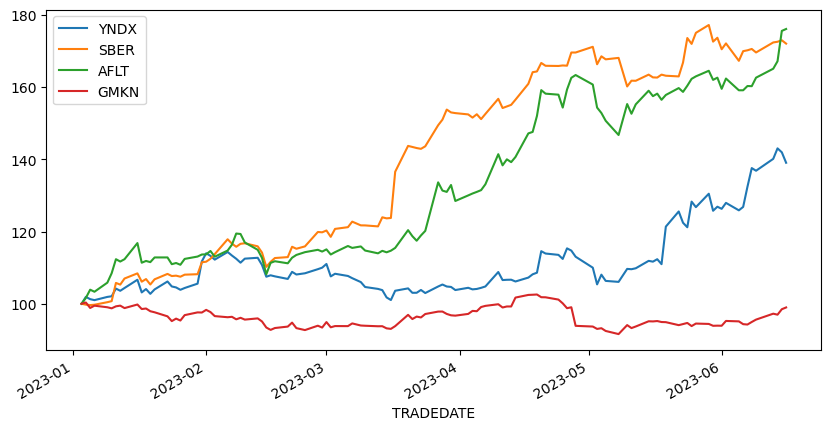

In [5]:
import matplotlib.pyplot as plt


(df / df.iloc[0] * 100).plot(figsize=(10, 5))
plt.show()

In [7]:
import numpy as np


returns = df / df.shift(1) # Доходность
log_returns = np.log(returns) # Лог-доходность

# ГЕНЕРАЦИЯ ВОЗМОЖНЫХ ПОРТФЕЛЕЙ
n = 10000 # Кол-во портфелей
weight = np.zeros((n, 4)) # Массив весовых коэффициентов
expected_return = np.zeros(n) # Массив ожидаемых доходностей
expected_volatility = np.zeros(n) # Массив ожидаемых волатильностей
sharpe_ratio = np.zeros(n) # Массив коэффициентов Шарпа

mean_log_return = log_returns.mean() # Средняя лог-доходность
sigma = log_returns.cov() # Матрица ковариации

for i in range(n):
    # Генерация случайного весового вектора
    w = np.array(np.random.random(4))
    w = w / np.sum(w)
    weight[i,:] = w
    # Ожидаемая лог-доходность
    expected_return[i] = np.sum(mean_log_return * w)
    # Ожидаемая волатильность
    expected_volatility[i] = np.sqrt(np.dot(w.T, np.dot(sigma, w)))
    # Коэффициент Шарпа
    sharpe_ratio[i] =  expected_return[i] / expected_volatility[i]

max_index = sharpe_ratio.argmax() # Портфель, имеющий наибольший коэффициент Шарпа

In [43]:
print("Весовые коэффициенты портфеля при max(SR)\n-----------------------------------------")
print(f"YNDX: {weight[max_index, :][0]}\nSBER: {weight[max_index, :][1]}\nAFLT: {weight[max_index, :][2]}\nGMKN: {weight[max_index, :][3]}")

Весовые коэффициенты портфеля при max(SR)
-----------------------------------------
YNDX: 0.010388732878812824
SBER: 0.6051908709261029
AFLT: 0.3752931173759064
GMKN: 0.009127278819177787


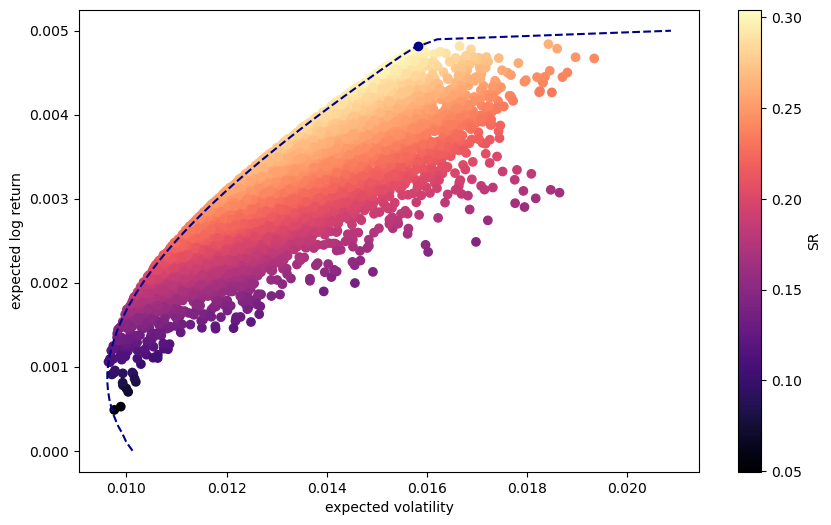

In [16]:
plt.figure(figsize=(10, 6))
plt.scatter(expected_volatility, expected_return, c=sharpe_ratio, cmap="magma")
plt.xlabel("expected volatility")
plt.ylabel("expected log return")
plt.colorbar(label="SR")
plt.scatter(expected_volatility[max_index],  expected_return[max_index], c="darkblue")
plt.plot(volatility_opt, returns , "--", c="darkblue")
plt.show()

In [106]:
# Граница Эффективности
def negative_SR(w):
    w = np.array(w)
    R = np.sum(mean_log_return * w)
    V = np.sqrt(np.dot(w.T, np.dot(sigma, w)))
    SR = R / V
    return -1 * SR

def check_sum(w):
    return np.sum(w) - 1

w0 = [0.25, 0.25, 0.25, 0.25]
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))
constraints = ({"type": "eq", "fun": check_sum})
w_opt = minimize(negative_SR,
                 w0,
                 method="SLSQP",
                 bounds=bounds,
                 constraints=constraints)
w_opt

     fun: -0.30487192077738545
     jac: array([-0.00032508,  0.00040248, -0.00066286,  0.07958493])
 message: 'Optimization terminated successfully'
    nfev: 36
     nit: 7
    njev: 7
  status: 0
 success: True
       x: array([3.78288586e-03, 6.19535435e-01, 3.76681679e-01, 5.43998440e-17])

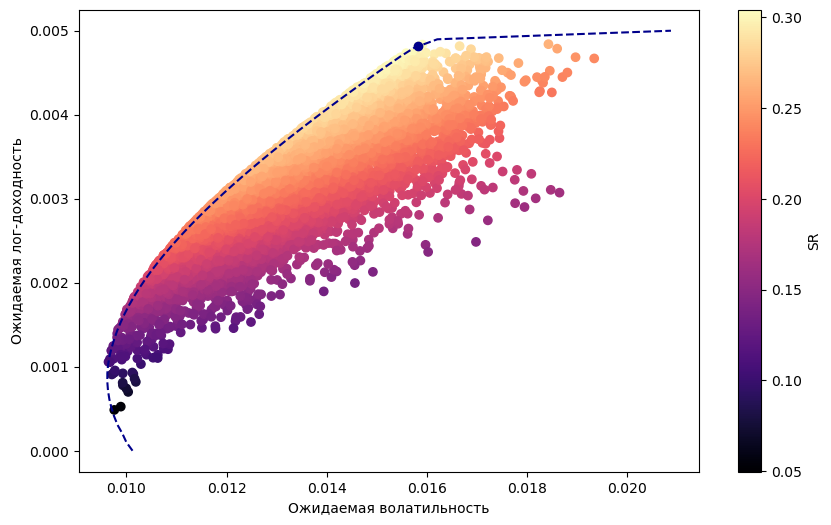

In [42]:
from scipy.optimize import minimize


# Входные параметры
w0 = [0.25, 0.25, 0.25, 0.25]
bounds = ((0, 1), (0, 1), (0, 1), (0, 1))
returns = np.linspace(0, 0.005, 50)
volatility_opt = []

# Функция минимизации
def minimize_volatility(w):
    w = np.array(w)
    V = np.sqrt(np.dot(w.T, np.dot(sigma, w)))
    return V

# Ограничения
def check_sum(w):
    return np.sum(w) - 1

def get_return(w):
    w = np.array(w)
    R = np.sum(mean_log_return * w)
    return R

# Поиск оптимальной волатильности
for i in returns:
    constraints = ({"type": "eq", "fun": check_sum},
                   {"type": "eq",
                    "fun": lambda w: get_return(w) - i})
    opt = minimize(minimize_volatility,
                   w0,
                   method="SLSQP",
                   bounds=bounds,
                   constraints=constraints)
    volatility_opt.append(opt["fun"])

# Построение графика
plt.figure(figsize=(10, 6))
plt.scatter(expected_volatility, expected_return, c=sharpe_ratio, cmap="magma")
plt.xlabel("Ожидаемая волатильность")
plt.ylabel("Ожидаемая лог-доходность")
plt.colorbar(label="SR")
plt.scatter(expected_volatility[max_index],  expected_return[max_index], c="darkblue")
plt.plot(volatility_opt, returns , "--", c="darkblue")
plt.show()